# A/B Testing Spanish Translation

## Goal

In this challenge, you will have to analyze results from an A/B test. Also, you will be asked to design an algorithm to automate some steps.

## Challenge Description

Company XYZ is a worldwide e-commerce site with localized versions of the site.

A data scientist at XYZ noticed that Spain-based users have a much higher conversion rate than any other Spanish-speaking country.

Spain and LatAm country manager suggested that one reason could be translation. All Spanish-speaking countries had the same translation of the site which was written by a Spaniard. Therefore, they agreed to try a test where each country would have its own translation written by a local. That is, Argentinian users would see a translation written by an Argentinian, Mexican users written by a Mexican and so on. Obviously, nothing would change for users from Spain.

After they run the test however, they are really surprised because the test is negative. That is, it appears that the non-highly localized translation was doing better!

You are asked to:

* Confirm that test is actually negative. I.e., the old version of the site with just one translation across Spain and LatAm performs better

* Explain why that might be happening. Are the localized translations really worse?

* If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and results can be trusted.

## 1. Load Data

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 350)

In [2]:
df_user = pd.read_csv('user_table.csv')
df_test = pd.read_csv('test_table.csv')

In [3]:
df_user.shape
df_user.head()

(452867, 4)

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [4]:
df_user.isna().sum()

user_id    0
sex        0
age        0
country    0
dtype: int64

In [5]:
df_test.shape
df_test.head()

(453321, 9)

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [6]:
df_test.isna().sum()

user_id                  0
date                     0
source                   0
device                   0
browser_language         0
ads_channel         271444
browser                  0
conversion               0
test                     0
dtype: int64

In [7]:
df = df_test.merge(df_user)
df.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19,Mexico


In [8]:
df.describe()

,user_id,conversion,test,age
count,452867.000000,452867.000000,452867.000000,452867.000000
mean,499944.805166,0.049560,0.476462,27.130740
std,288676.264784,0.217034,0.499446,6.776678
min,1.000000,0.000000,0.000000,18.000000
25%,249819.000000,0.000000,0.000000,22.000000
50%,500019.000000,0.000000,0.000000,26.000000
75%,749543.000000,0.000000,1.000000,31.000000
max,1000000.000000,1.000000,1.000000,70.000000


## Question 1

Confirm that test is actually negative. I.e., the old version of the site with just one translation across Spain and LatAm performs better

Check Spain's conversion rate

In [9]:
df[df['test'] == 0].groupby('country')['conversion'].mean().sort_values()

country
Uruguay        0.012048
Argentina      0.015071
Panama         0.046796
Chile          0.048107
Paraguay       0.048493
Ecuador        0.049154
Bolivia        0.049369
Mexico         0.049495
Peru           0.049914
Venezuela      0.050344
Guatemala      0.050643
Honduras       0.050906
Colombia       0.052089
Costa Rica     0.052256
Nicaragua      0.052647
El Salvador    0.053554
Spain          0.079719
Name: conversion, dtype: float64

Check test & control results - t test

In [10]:
df_results = df.groupby(['test','country'])['conversion'].mean().unstack(level = 0)
df_results['diff'] = df_results[0] - df_results[1]
df_results

test,0,1,diff
country,,,
Argentina,0.015071,0.013725,0.001346
Bolivia,0.049369,0.047901,0.001468
Chile,0.048107,0.051295,-0.003188
Colombia,0.052089,0.050571,0.001519
Costa Rica,0.052256,0.054738,-0.002482
Ecuador,0.049154,0.048988,0.000165
El Salvador,0.053554,0.047947,0.005607
Guatemala,0.050643,0.048647,0.001996
Honduras,0.050906,0.047540,0.003366


In [11]:
from scipy import stats

In [12]:
df = df[df.country != 'Spain']

In [13]:
df.groupby('test')['conversion'].mean()

test
0    0.048292
1    0.043411
Name: conversion, dtype: float64

In [14]:
#t-test of test vs control for our target metric 
test = stats.ttest_ind(df[df['test'] == 1]['conversion'],
                      df[df['test'] == 0]['conversion'],
                      equal_var = False)

In [15]:
test.statistic
test.pvalue

-7.353895203080277

1.9289178577799033e-13

Day to day check

In [16]:
df['date']  = pd.to_datetime(df['date'])

<AxesSubplot:xlabel='date'>

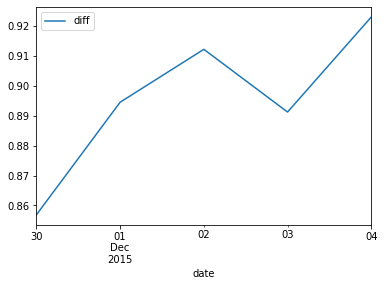

In [17]:
df.groupby('date')['conversion'].agg(diff = (lambda x: x[df['test'] == 1].mean()/x[df['test'] == 0].mean())).plot()

From the plot, we notice a couple of things:


1. Test has constantly been worse than control and there is relatively little variance across days. That probably means that we do have enough data, but there was some bias in the experiment set up


2. As a side note, we just ran it for 5 days. We should always run the test for at least 1 full week to capture weekly patterns, 2 weeks would be much better


Country distribution check

In [18]:
df_cot_rate = ((df.groupby(['test','country'])['user_id'].count()) / (df.groupby(['test'])['user_id'].count())).unstack(level = 0)
df_cot_rate

test,0,1
country,,
Argentina,0.050488,0.173223
Bolivia,0.029950,0.025833
Chile,0.053170,0.045807
Colombia,0.146176,0.125001
Costa Rica,0.014354,0.012277
Ecuador,0.043365,0.036422
El Salvador,0.022168,0.018848
Guatemala,0.041131,0.034772
Honduras,0.023533,0.019497


In [19]:
df_cot_rate['diff'] = df_cot_rate[0] - df_cot_rate[1]
df_cot_rate

test,0,1,diff
country,,,
Argentina,0.050488,0.173223,-0.122735
Bolivia,0.029950,0.025833,0.004117
Chile,0.053170,0.045807,0.007363
Colombia,0.146176,0.125001,0.021175
Costa Rica,0.014354,0.012277,0.002078
Ecuador,0.043365,0.036422,0.006943
El Salvador,0.022168,0.018848,0.003320
Guatemala,0.041131,0.034772,0.006358
Honduras,0.023533,0.019497,0.004036


Source distribution check

In [20]:
(df.groupby(['test','source'])['user_id'].count()/df.groupby('test')['user_id'].count()).unstack(level = 0)

test,0,1
source,,
Ads,0.401228,0.400641
Direct,0.200949,0.199500
SEO,0.397823,0.399858


## Check Distribution Using Machine Learning

Check manually is timeconsuming, so we use machine learning

In [21]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree
import pydotplus
from IPython.display import Image

In [22]:
df.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21,Mexico
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19,Mexico
5,540675,2015-12-03,Direct,Mobile,ES,NaN,Android_App,0,1,F,22,Venezuela
6,863394,2015-12-04,SEO,Mobile,Other,NaN,Android_App,0,0,M,35,Mexico


In [23]:
df_tree = df.drop(columns = 'conversion')

In [24]:
df_tree['date'] = df_tree['date'].apply(str)

In [25]:
#make dummy vars. Don't drop one level here, keep them all. You don't want to risk dropping the one level that actually creates problems with the randomization
df_tree_dm = pd.get_dummies(df_tree)

In [26]:
X = df_tree_dm.drop(columns = 'test')
y = df_tree_dm.test

In [27]:
dt = DecisionTreeClassifier(class_weight = 'balanced', min_impurity_decrease = 0.001)

In [28]:
dt.fit(X, y)

DecisionTreeClassifier(class_weight='balanced', min_impurity_decrease=0.001)

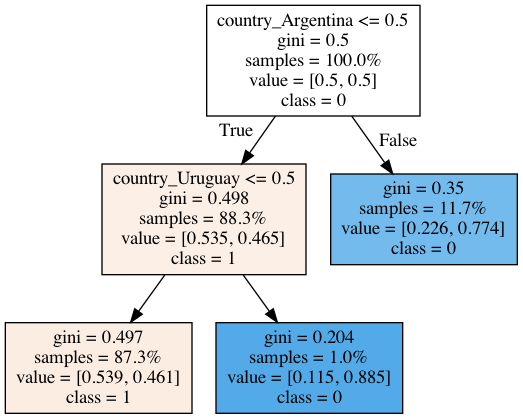

In [29]:
class_feature = X.columns
class_target = [str(s) for s in y.unique()]

tree.export_graphviz(dt,
                     out_file='tree1.dot',
                    feature_names=class_feature,
                    class_names=class_target,
                    filled=True,
                    proportion=True)
graph = pydotplus.graph_from_dot_file('tree1.dot')
Image(graph.create_png())

we can see that test and control are not the same! Users from Argentina and Uruguay are way more likely to be in test than control. 

## Confirm Tree Result

In [30]:
df_removed = df[(df.country != 'Argentina') & (df.country != 'Uruguay')]

In [31]:
test = stats.ttest_ind(df_removed[df_removed.test == 1]['conversion'],
               df_removed[df_removed.test == 0]['conversion'],
               equal_var=False)

In [32]:
test.pvalue
test.statistic

0.7200849282884506

0.3583455794481446

Check by country

In [33]:
df.groupby('country')['conversion'].agg(pvalue = lambda x: stats.ttest_ind(x[df['test'] == 1],
                                                                          x[df['test'] == 0],
                                                                          equal_var=False).pvalue,
                                       conversion_test = lambda x: x[df.test == 1].mean(),
                                       conversion_control = lambda x: x[df.test == 0].mean())

,pvalue,conversion_test,conversion_control
country,,,
Argentina,0.335147,0.013725,0.015071
Bolivia,0.718885,0.047901,0.049369
Chile,0.302848,0.051295,0.048107
Colombia,0.423719,0.050571,0.052089
Costa Rica,0.687876,0.054738,0.052256
Ecuador,0.961512,0.048988,0.049154
El Salvador,0.248127,0.047947,0.053554
Guatemala,0.572107,0.048647,0.050643
Honduras,0.471463,0.047540,0.050906


Non-significant across all countries